In [1]:
!unzip -q /content/alz-evidence-qa.zip -d /content

In [4]:
#set project root, make src a package, and import modules

import sys
from pathlib import Path

PROJECT_ROOT = Path("/content/alz-evidence-qa").resolve()
print("Using PROJECT_ROOT:", PROJECT_ROOT)

SRC_DIR = PROJECT_ROOT / "src"
print("SRC_DIR:", SRC_DIR)

init_file = SRC_DIR / "__init__.py"
if not init_file.exists():
    init_file.touch()
    print("Created __init__.py in src/")
else:
    print("__init__.py already exists in src/")


if str(PROJECT_ROOT) not in sys.path:
    sys.path.append(str(PROJECT_ROOT))

from src.utils import (
    create_project_directories,
    RAW_TRAIN_DIR,
    RAW_TEST_DIR,
    load_bioasq_tree,
    filter_ad_questions,
)

from src.retriever import RetrievalPipeline
from src.evaluator import (
    build_full_corpus,
    evaluate_retrieval_variant,
    select_best_dense_model,
    load_qa_model,
    evaluate_qa,
    preview_question_with_titles,
)

create_project_directories()

print("Train/dev JSONs should be under:", RAW_TRAIN_DIR)
print("Test JSONs should be under:", RAW_TEST_DIR)


Using PROJECT_ROOT: /content/alz-evidence-qa
SRC_DIR: /content/alz-evidence-qa/src
__init__.py already exists in src/
Train/dev JSONs should be under: /content/alz-evidence-qa/data/bioasq_raw
Test JSONs should be under: /content/alz-evidence-qa/data/bioasq_test


In [5]:
#load BioASQ JSONs and filter to AD / dementia

all_train_questions = load_bioasq_tree(RAW_TRAIN_DIR)
all_test_questions = load_bioasq_tree(RAW_TEST_DIR)

ad_train_questions = filter_ad_questions(all_train_questions)
ad_test_questions = filter_ad_questions(all_test_questions)

print("Total train/dev questions:", len(all_train_questions))
print("AD train/dev questions:", len(ad_train_questions))
print("Total test questions:", len(all_test_questions))
print("AD test questions:", len(ad_test_questions))


Total train/dev questions: 27368
AD train/dev questions: 304
Total test questions: 1993
AD test questions: 17


In [6]:
#build PMID corpus from AD TRAIN ONLY (snippets + PubMed abstracts)

email_for_ncbi = "somamohanty58@gmail.com"

corpus = build_full_corpus(
    train_questions=ad_train_questions,
    extra_questions=None,
    email=email_for_ncbi,
)

print("Corpus PMIDs (from AD-train):", len(corpus.texts))


Corpus PMIDs (from AD-train): 499


In [7]:
# build index + TF-IDF matrix

pipeline = RetrievalPipeline(corpus=corpus)
pipeline.build()

print("Whoosh BM25 index and TF-IDF matrix built.")


Whoosh BM25 index and TF-IDF matrix built.


In [8]:
# add dense retrievers, load reranker, select BEST_DENSE on a subset of AD-train

import random

# Encode corpus with candidate dense models
pipeline.add_dense_model("e5", "intfloat/e5-small-v2")
pipeline.add_dense_model("specter", "sentence-transformers/allenai-specter")
pipeline.add_dense_model("pubmedbert", "pritamdeka/S-PubMedBERT-MS-MARCO")

pipeline.load_bge_reranker()

# Use only a small subset of AD-train for model selection
random.seed(0)
max_dev_questions = 50
if len(ad_train_questions) > max_dev_questions:
    dev_subset = random.sample(ad_train_questions, max_dev_questions)
else:
    dev_subset = ad_train_questions

print("Using", len(dev_subset), "AD-train questions for dense model selection.")

BEST_DENSE = select_best_dense_model(
    pipeline=pipeline,
    dev_questions=dev_subset,
    dense_model_names=["e5", "specter", "pubmedbert"],
)

print("BEST_DENSE model selected on AD-train subset:", BEST_DENSE)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/387 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/57.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/133M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/314 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/200 [00:00<?, ?B/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/622 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/331 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/123 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/666 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/388 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

config.json:   0%|          | 0.00/799 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/443 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/279 [00:00<?, ?B/s]

Using 50 AD-train questions for dense model selection.
== E5 fusion+rerank (dev) ==
Recall@20: 0.784  nDCG@10: 0.684  MAP: 0.688
Raw R@10: 0.715  Cap-normalized R@10: 0.783

== SPECTER fusion+rerank (dev) ==
Recall@20: 0.782  nDCG@10: 0.689  MAP: 0.695
Raw R@10: 0.717  Cap-normalized R@10: 0.785

== PUBMEDBERT fusion+rerank (dev) ==
Recall@20: 0.783  nDCG@10: 0.678  MAP: 0.681
Raw R@10: 0.713  Cap-normalized R@10: 0.781

Best dense model on dev: specter
BEST_DENSE model selected on AD-train subset: specter


In [9]:
#  Retrieval evaluation on AD-TRAIN

def retrieve_baseline(query_text: str, topk: int = 20):
    """BM25(relaxed) + TF-IDF(relaxed) baseline."""
    return pipeline.retrieve_bm25_tfidf(query_text, topk=topk)

def retrieve_dense_best(query_text: str, topk: int = 20):
    """BM25 + TF-IDF + BEST_DENSE + cross-encoder rerank."""
    return pipeline.retrieve_with_dense_rerank(
        query_text,
        dense_name=BEST_DENSE,
        topk=topk,
        pool_k=300,
    )

print("=== AD-TRAIN retrieval metrics ===")
train_baseline_metrics = evaluate_retrieval_variant(
    questions=ad_train_questions,
    retrieve_fn=retrieve_baseline,
    variant_name="BM25(relaxed) + TF-IDF(relaxed) (train)",
    topk=20,
)

train_dense_metrics = evaluate_retrieval_variant(
    questions=ad_train_questions,
    retrieve_fn=retrieve_dense_best,
    variant_name=f"BM25 + TF-IDF + {BEST_DENSE.upper()} + reranker (train)",
    topk=20,
)


=== AD-TRAIN retrieval metrics ===
== BM25(relaxed) + TF-IDF(relaxed) (train) ==
Recall@20: 0.512  nDCG@10: 0.445  MAP: 0.483
Raw R@10: 0.387  Cap-normalized R@10: 0.474

== BM25 + TF-IDF + SPECTER + reranker (train) ==
Recall@20: 0.739  nDCG@10: 0.653  MAP: 0.668
Raw R@10: 0.616  Cap-normalized R@10: 0.713



In [10]:
# Retrieval evaluation on AD-TEST

print("=== AD-TEST retrieval metrics ===")
test_baseline_metrics = evaluate_retrieval_variant(
    questions=ad_test_questions,
    retrieve_fn=retrieve_baseline,
    variant_name="BM25(relaxed) + TF-IDF(relaxed) (test)",
    topk=20,
)

test_dense_metrics = evaluate_retrieval_variant(
    questions=ad_test_questions,
    retrieve_fn=retrieve_dense_best,
    variant_name=f"BM25 + TF-IDF + {BEST_DENSE.upper()} + reranker (test)",
    topk=20,
)


=== AD-TEST retrieval metrics ===
== BM25(relaxed) + TF-IDF(relaxed) (test) ==
Recall@20: 0.538  nDCG@10: 0.393  MAP: 0.400
Raw R@10: 0.370  Cap-normalized R@10: 0.424

== BM25 + TF-IDF + SPECTER + reranker (test) ==
Recall@20: 0.695  nDCG@10: 0.602  MAP: 0.590
Raw R@10: 0.571  Cap-normalized R@10: 0.675



In [11]:
# Load instruction-tuned LLM for QA

qa_model_bundle = load_qa_model("TinyLlama/TinyLlama-1.1B-Chat-v1.0")
print("QA model loaded on device:", qa_model_bundle.device)


tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/608 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors:   0%|          | 0.00/2.20G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

QA model loaded on device: cuda


In [12]:
# QA evaluation on AD-TRAIN

train_qa_metrics = evaluate_qa(
    questions=ad_train_questions,
    pipeline=pipeline,
    qa_model=qa_model_bundle,
    dense_name=BEST_DENSE,
    topk=20,
    save_prefix="train_answers20_llm",
)

print("AD-TRAIN QA metrics:", train_qa_metrics)


The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


ROUGE-L (vs ideal): 0.233   Exact: 0.51
Saved: train_answers20_llm_20251212-165953.jsonl train_answers20_llm_metrics_20251212-165953.json
AD-TRAIN QA metrics: {'rougeL_mean': 0.23283926533029514, 'exact_mean': 0.5098684210526315}


In [13]:
# QA evaluation on AD-TEST

test_qa_metrics = evaluate_qa(
    questions=ad_test_questions,
    pipeline=pipeline,
    qa_model=qa_model_bundle,
    dense_name=BEST_DENSE,
    topk=20,
    save_prefix="test_answers20_llm",
)

print("AD-TEST QA metrics:", test_qa_metrics)


ROUGE-L (vs ideal): 0.257   Exact: 0.647
Saved: test_answers20_llm_20251212-170303.jsonl test_answers20_llm_metrics_20251212-170303.json
AD-TEST QA metrics: {'rougeL_mean': 0.2571195064244831, 'exact_mean': 0.6470588235294118}


AD-TRAIN metrics:
  Baseline (BM25+TF-IDF):       R@10=0.387, nDCG@10=0.445
  +SPECTER+BGE:               R@10=0.616, nDCG@10=0.653

AD-TEST metrics:
  Baseline (BM25+TF-IDF):       R@10=0.370, nDCG@10=0.393
  +SPECTER+BGE:               R@10=0.571, nDCG@10=0.602


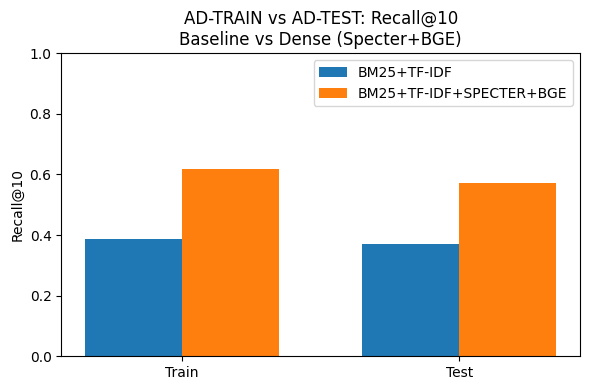

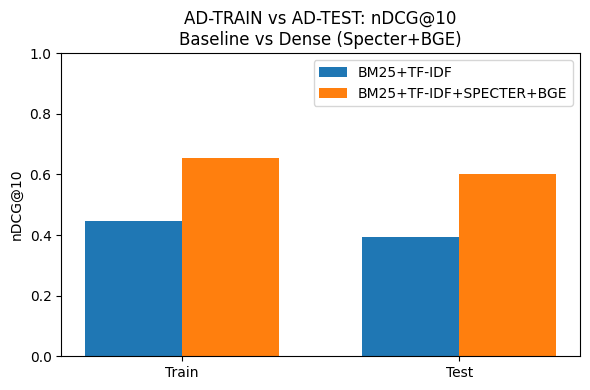

In [14]:
# Graphs: BM25+TF-IDF vs BM25+TF-IDF+Dense+BGE on AD-TRAIN / AD-TEST

import numpy as np
import matplotlib.pyplot as plt


# Recall@10 = raw_r10 in RetrievalMetrics
train_r10_baseline = float(train_baseline_metrics.raw_r10)
train_r10_dense    = float(train_dense_metrics.raw_r10)
test_r10_baseline  = float(test_baseline_metrics.raw_r10)
test_r10_dense     = float(test_dense_metrics.raw_r10)

# nDCG@10 = ndcg_at_10
train_ndcg_baseline = float(train_baseline_metrics.ndcg_at_10)
train_ndcg_dense    = float(train_dense_metrics.ndcg_at_10)
test_ndcg_baseline  = float(test_baseline_metrics.ndcg_at_10)
test_ndcg_dense     = float(test_dense_metrics.ndcg_at_10)

print("AD-TRAIN metrics:")
print(f"  Baseline (BM25+TF-IDF):       R@10={train_r10_baseline:.3f}, nDCG@10={train_ndcg_baseline:.3f}")
print(f"  +{BEST_DENSE.upper()}+BGE:               R@10={train_r10_dense:.3f}, nDCG@10={train_ndcg_dense:.3f}")

print("\nAD-TEST metrics:")
print(f"  Baseline (BM25+TF-IDF):       R@10={test_r10_baseline:.3f}, nDCG@10={test_ndcg_baseline:.3f}")
print(f"  +{BEST_DENSE.upper()}+BGE:               R@10={test_r10_dense:.3f}, nDCG@10={test_ndcg_dense:.3f}")

labels = ["Train", "Test"]
baseline_recalls = [train_r10_baseline, test_r10_baseline]
dense_recalls    = [train_r10_dense,    test_r10_dense]

x = np.arange(len(labels))
width = 0.35

plt.figure(figsize=(6, 4))
plt.bar(x - width/2, baseline_recalls, width, label="BM25+TF-IDF")
plt.bar(x + width/2, dense_recalls,    width, label=f"BM25+TF-IDF+{BEST_DENSE.upper()}+BGE")

plt.xticks(x, labels)
plt.ylabel("Recall@10")
plt.ylim(0.0, 1.0)
plt.title("AD-TRAIN vs AD-TEST: Recall@10\nBaseline vs Dense (Specter+BGE)")
plt.legend()
plt.tight_layout()
plt.show()


baseline_ndcg = [train_ndcg_baseline, test_ndcg_baseline]
dense_ndcg    = [train_ndcg_dense,    test_ndcg_dense]

plt.figure(figsize=(6, 4))
plt.bar(x - width/2, baseline_ndcg, width, label="BM25+TF-IDF")
plt.bar(x + width/2, dense_ndcg,    width, label=f"BM25+TF-IDF+{BEST_DENSE.upper()}+BGE")

plt.xticks(x, labels)
plt.ylabel("nDCG@10")
plt.ylim(0.0, 1.0)
plt.title("AD-TRAIN vs AD-TEST: nDCG@10\nBaseline vs Dense (Specter+BGE)")
plt.legend()
plt.tight_layout()
plt.show()


In [15]:
#  Show top PMIDs + titles + LLM answer

num_examples_to_show = min(2, len(ad_test_questions))

for index in range(num_examples_to_show):
    print("=" * 80)
    preview_question_with_titles(
        question=ad_test_questions[index],
        pipeline=pipeline,
        qa_model=qa_model_bundle,
        dense_name=BEST_DENSE,
        topk=10,
    )
    print()


Question: Does αCGRP have amyloidogenic properties?

Top PMIDs and titles:
- 33023198: (No title fetched)
- 29501724: (No title fetched)
- 17662457: An aluminum-based rat model for Alzheimer's disease exhibits oxidative damage, inhibition of PP2A activity, hyperphosphorylated tau, and granulovacuolar degeneration.
- 23551149: (No title fetched)
- 37905874: (No title fetched)
- 19363993: [Transthyretin: it's miracle function and pathogenesis].
- 21624562: (No title fetched)
- 20360050: Beneficial effect of human anti-amyloid-beta active immunization on neurite morphology and tau pathology.
- 20826658: Abeta oligomers cause localized Ca(2+) elevation, missorting of endogenous Tau into dendrites, Tau phosphorylation, and destruction of microtubules and spines.
- 15014128: Neuron-specific apolipoprotein e4 proteolysis is associated with increased tau phosphorylation in brains of transgenic mice.

LLM answer:
In this work, we investigated the amyloidogenic profile of αCGRP, a 37-residue-lon